#### Libraries, Helpers & API Configuration

In [44]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import sklearn
from ast import literal_eval

In [76]:
# base code
import numpy as np
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-v0_8-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-v0_8-paper', **kwargs):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y

In [91]:
data.id.nunique()

513

In [92]:
data.columns

Index(['Year', 'Release', 'Gross', 'Max Th', 'Opening', '% of Total',
       'Open Th', 'Open', 'Close', 'Distributor', 'adult_x', 'backdrop_path_x',
       'genre_ids', 'id', 'original_language_x', 'original_title_x',
       'overview_x', 'popularity_x', 'poster_path_x', 'release_date_x',
       'title_x', 'video_x', 'vote_average_x', 'vote_count_x', 'adult_y',
       'backdrop_path_y', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'imdb_id', 'origin_country', 'original_language_y',
       'original_title_y', 'overview_y', 'popularity_y', 'poster_path_y',
       'production_companies', 'production_countries', 'release_date_y',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title_y', 'video_y', 'vote_average_y', 'vote_count_y',
       'belongs_to_collection.id', 'belongs_to_collection.name',
       'belongs_to_collection.poster_path',
       'belongs_to_collection.backdrop_path'],
      dtype='object')

In [108]:
first_cut = data[['id', 'Release', 'release_date_x', 'Opening', '% of Total', 'Open Th',
       'genre_ids', 'original_language_x', 'popularity_x', 'vote_average_x', 'vote_count_x',  'budget', 'genres', 
        'imdb_id', 'origin_country','production_companies', 'production_countries',
       'revenue', 'runtime', 'belongs_to_collection.id', 'belongs_to_collection.name']]

In [109]:
first_cut = first_cut.rename(columns = {'Release' : 'release', 'release_date_x' : 'release_date', 'Opening' : 'opening_revenue', '% of Total' : 'percent_of_total_revenue', 'Open Th' : 'opening_theaters', 'original_language_x' : 'original_language', 'popularity_x' : 'popularity', 'vote_average_x': 'vote_average', 'vote_count_x' : 'vote_count'})

In [110]:
#first_cut.to_csv('first_cut.csv')

In [1098]:
X = end_point[[
 'budget',
 'runtime',
 'num_production_companies',
 'release_month_1',
 'release_month_2',
 'release_month_3',
 'release_month_4',
 'release_month_5',
 'release_month_6',
 'release_month_7',
 'release_month_8',
 'release_month_9',
 'release_month_10',
 'release_month_11',
 'release_month_12',
 12,
 14,
 16,
 18,
 27,
 28,
 35,
 36,
 37,
 53,
 80,
 99,
 878,
 9648,
 10402,
 10749,
 10751,
 10752,
'is_series',
'position_in_series',    
'writer_xp_median', 'writer_xp_sum', 'writer_rating_median', 'writer_rating_max',
'cast_xp_median', 'cast_xp_sum', 'cast_rating_max',
'director_xp', 'director_rating_median', 'director_rating_max',
'production_room', 'writers_room', 'sound_room', 'crew', 'based_on_novel',
 'previous_film_release',
 'previous_film_rating']]

In [1099]:
lim = len(X.columns) + 1

In [1100]:
X = X.fillna(0)

In [1101]:
result_df = pd.DataFrame()
i = 0
cut = X.columns.to_list()

while i < lim:
    subset = X[cut]
    subset = sm.add_constant(subset)
    Y = pd.DataFrame(np.sqrt(end_point['opening_revenue']))
    model = sm.OLS(Y, subset)
    results = model.fit()
    rsquared_adj = results.rsquared_adj
    columns = subset.columns.to_list()
    d = pd.DataFrame({'model' : i, 'feature_count' : len(subset.columns), 'adj_rsquared' : rsquared_adj, 'feature_space' : [columns]}, index = [i])
    result_df = pd.concat([result_df, d])
    
    pvals = pd.DataFrame(results.pvalues).sort_values(by = 0, ascending = False).reset_index()
    pvals = pvals[pvals['index'] != 'const']
    cut = pvals['index'].to_list()[1:]
    i = i + 1


In [1102]:
result_df

,model,feature_count,adj_rsquared,feature_space
0,0,53,0.616356,"[const, budget, runtime, num_production_compan..."
1,1,52,0.617193,"[const, writer_xp_median, release_month_11, 96..."
2,2,51,0.618026,"[const, release_month_11, 9648, release_month_..."
3,3,50,0.618026,"[const, 9648, release_month_4, release_month_5..."
4,4,49,0.618856,"[const, release_month_5, 9648, 12, 16, 36, 107..."
5,5,48,0.619682,"[const, 9648, 12, 16, 36, 10749, 10751, 28, re..."
6,6,47,0.620499,"[const, 12, 36, 16, 10749, 10751, 28, release_..."
7,7,46,0.621306,"[const, 16, 36, 10749, 10751, 28, release_mont..."
8,8,45,0.622105,"[const, 36, 10749, 10751, release_month_7, 28,..."
9,9,44,0.622898,"[const, 10749, 10751, release_month_7, 28, cre..."


In [1103]:
cut = result_df.sort_values(by = 'adj_rsquared', ascending = False).reset_index().feature_space[0]
cut.remove('const')

final = X[cut]
final = sm.add_constant(final)
Y = pd.DataFrame(np.sqrt(baseline['opening_revenue']))

model = sm.OLS(Y, final)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        opening_revenue   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     33.01
Date:                Thu, 24 Oct 2024   Prob (F-statistic):           7.08e-92
Time:                        02:08:23   Log-Likelihood:                -4348.2
No. Observations:                 509   AIC:                             8752.
Df Residuals:                     481   BIC:                             8871.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

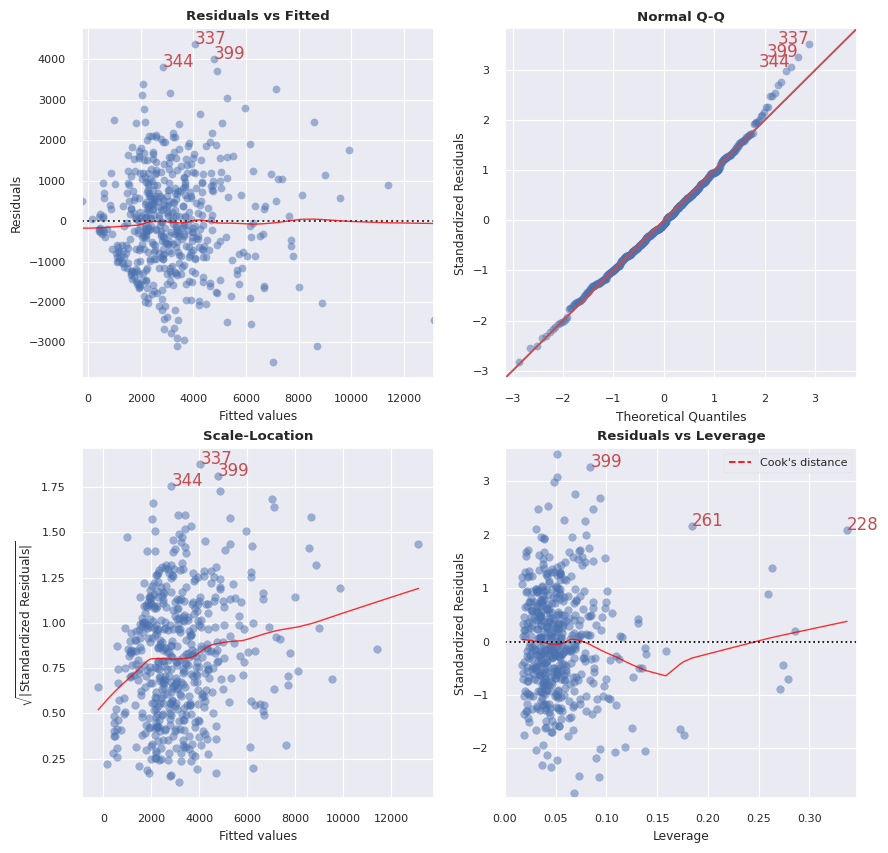

In [1104]:
cls = LinearRegDiagnostic(results)
vif, fig, ax = cls()

In [2]:
#end_point.to_csv('third_cut.csv')

#### **SoD Model, 63.4% |** Thursday, October 24th

In [93]:
data = pd.read_csv('baseline_clean_10-24-CL.csv', index_col=0, converters={'production_companies': literal_eval}, parse_dates=['release_date'])
data['release_date'] = pd.to_datetime(data['release_date'], format='%Y-%m-%d')

In [94]:
data.columns

Index(['id', 'release', 'release_date', 'opening_revenue', 'original_language',
       'budget', 'origin_country', 'production_companies', 'runtime',
       'position_in_series', 'previous_film_release', 'previous_film_rating',
       'cast_xp_median', 'cast_xp_sum', 'cast_rating_max', 'director',
       'director_xp', 'director_rating_median', 'director_rating_max',
       'writer', 'writer_xp_median', 'writer_xp_sum', 'writer_rating_median',
       'writer_rating_max', 'production_room', 'writers_room', 'sound_room',
       'crew', 'based_on_novel', 'num_production_companies', 'is_series',
       'release_month_1', 'release_month_2', 'release_month_3',
       'release_month_4', 'release_month_5', 'release_month_6',
       'release_month_7', 'release_month_8', 'release_month_9',
       'release_month_10', 'release_month_11', 'release_month_12', '12', '14',
       '16', '18', '27', '28', '35', '36', '37', '53', '80', '99', '878',
       '9648', '10402', '10749', '10751', '10752'],
    

Only difference to EoD on 10/23 is num_prod_companies is appropriately encoded

In [95]:
X = data[['budget', 'runtime',
       'is_series', 'num_production_companies', 'release_month_1',
       'release_month_2', 'release_month_3', 'release_month_4',
       'release_month_5', 'release_month_6', 'release_month_7',
       'release_month_8', 'release_month_9', 'release_month_10',
       'release_month_11', 'release_month_12', '12', '14', '16', '18', '27',
       '28', '35', '36', '37', '53', '80', '99', '878', '9648', '10402',
       '10749', '10751', '10752', 'position_in_series',
       'previous_film_release', 'previous_film_rating', 'cast_xp_median',
       'cast_xp_sum', 'cast_rating_max', 'director', 'director_xp',
       'director_rating_median', 'director_rating_max', 'writer',
       'writer_xp_median', 'writer_xp_sum', 'writer_rating_median',
       'writer_rating_max', 'production_room', 'writers_room', 'sound_room',
       'crew', 'based_on_novel']]

X = X.fillna(0)

result_df = pd.DataFrame()
i = 0
cut = X.columns.to_list()
lim = len(cut) + 1

while i < lim:
    subset = X[cut]
    subset = sm.add_constant(subset)
    Y = pd.DataFrame(np.sqrt(data['opening_revenue']))
    model = sm.OLS(Y, subset)
    results = model.fit()
    rsquared_adj = results.rsquared_adj
    columns = subset.columns.to_list()
    d = pd.DataFrame({'model' : i, 'feature_count' : len(subset.columns), 'adj_rsquared' : rsquared_adj, 'feature_space' : [columns]}, index = [i])
    result_df = pd.concat([result_df, d])
    
    pvals = pd.DataFrame(results.pvalues).sort_values(by = 0, ascending = False).reset_index()
    pvals = pvals[pvals['index'] != 'const']
    cut = pvals['index'].to_list()[1:]
    i = i + 1

cut = result_df.sort_values(by = 'adj_rsquared', ascending = False).reset_index().feature_space[0]
cut.remove('const')

final = X[cut]
final = sm.add_constant(final)
Y = pd.DataFrame(np.sqrt(data['opening_revenue']))

model = sm.OLS(Y, final)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        opening_revenue   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     34.97
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           5.19e-93
Time:                        02:28:26   Log-Likelihood:                -4256.1
No. Observations:                 499   AIC:                             8566.
Df Residuals:                     472   BIC:                             8680.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

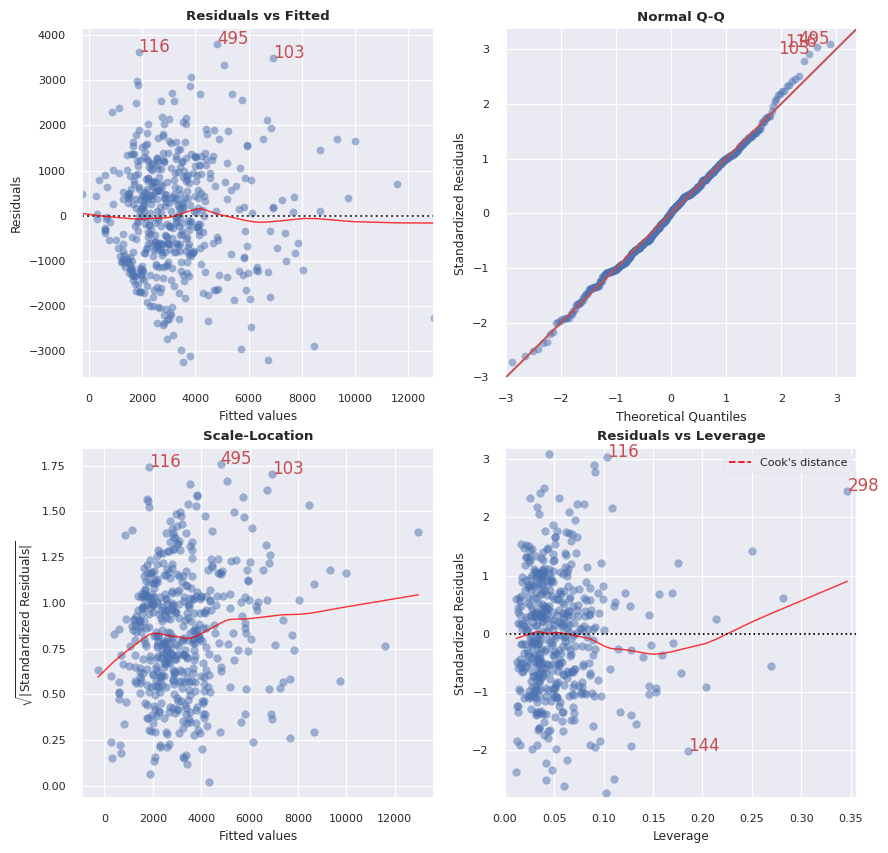

In [97]:
cls = LinearRegDiagnostic(results)
vif, fig, axs = cls()

#### Re: Assumptions from the Overall Model

##### *Nonlinearity* | Ok
A nice "cloud" of random scatter, with no clear collective trend in one direction or another. 

##### *Nonconstancy of Variance* | Not Ok
Definitely we're seeing a fairly significant case of fanning, particularly at the bottom. We can more clearly see this is a fairly textbook case when looking at the absolute value graph of things:

<Figure size 1170x827 with 0 Axes>

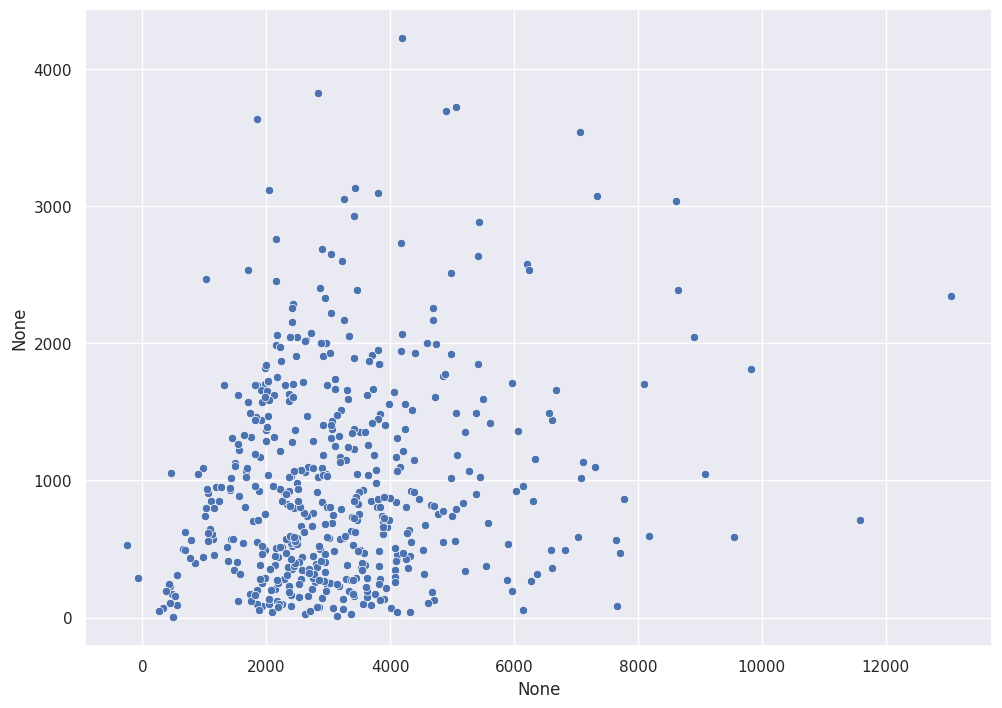

In [78]:
abs_y = abs(results.resid)
fitted = results.fittedvalues
fig0 = plt.figure()
sns.scatterplot(data=final, x=fitted, y=abs_y, ax=fig0.gca())
plt.show()

##### *Outliers* | Nothing > |4|

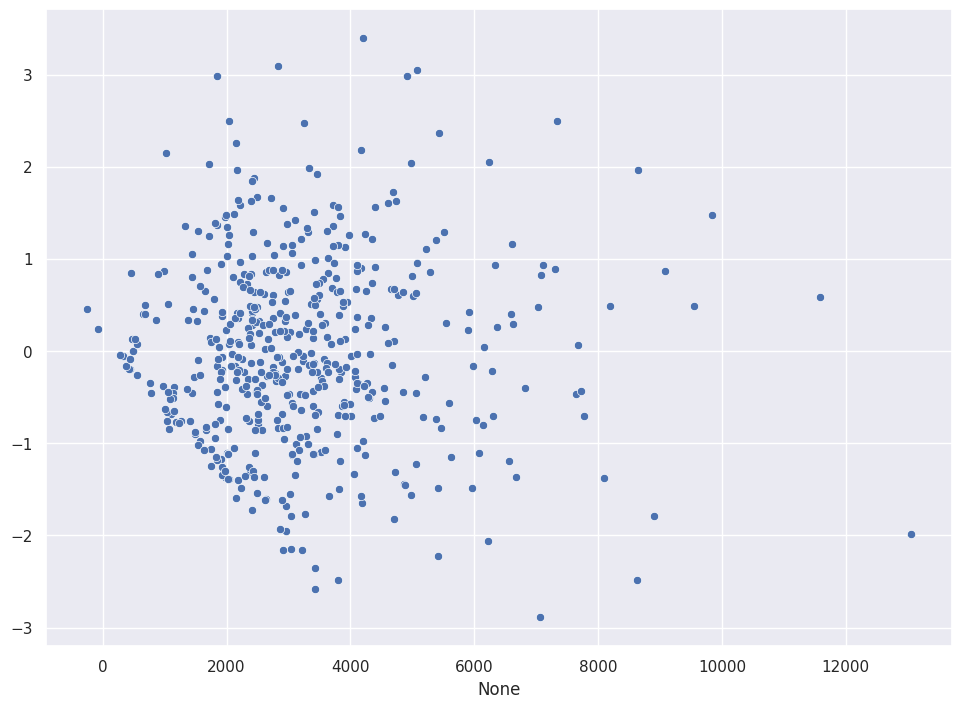

In [79]:
influence = results.get_influence()
studentized_residuals = influence.resid_studentized_internal
fig1 = plt.figure()
sns.scatterplot(data=final, x=fitted, y=studentized_residuals, ax=fig1.gca())
plt.show()

##### Nonindependence of Error Terms

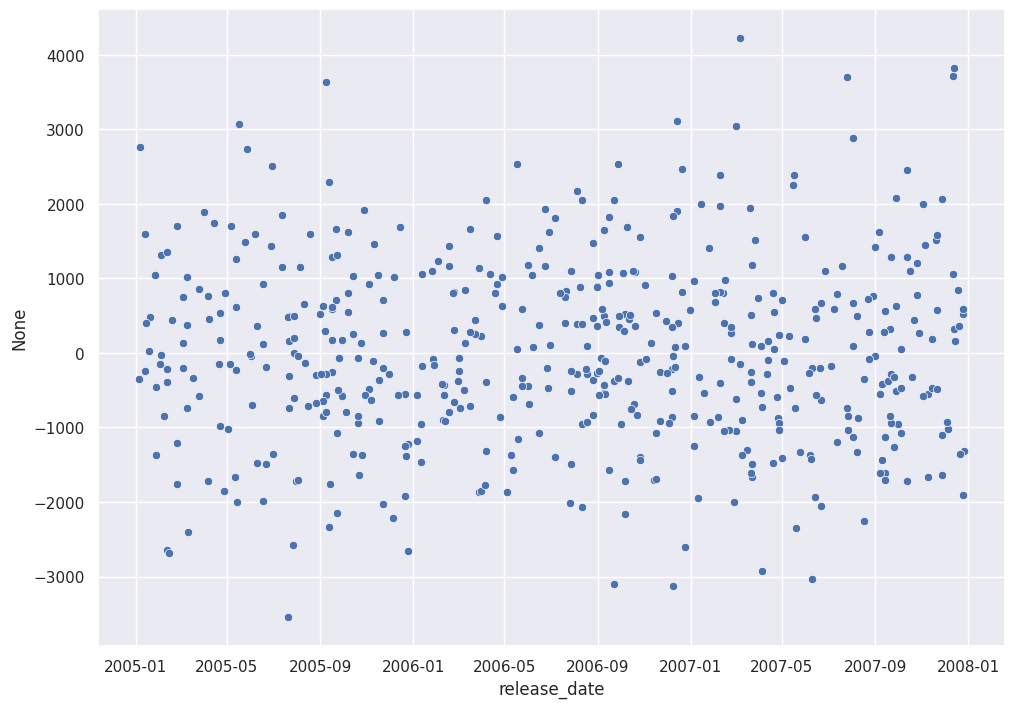

In [92]:
residuals = results.resid
time = data.release_date
fig3 = plt.figure()
sns.scatterplot(x=time, y=residuals, ax=fig3.gca())
plt.show()

Oh man was I worried we were screwed. This is the best plot I've seen lol

#### Validating Assumptions

Plotting the residual values against the fitted values, we graphically observe a fair amount of random scatter; although, there are a few trends / patterns that indicate a degree of general nonlinearity. To identify the source, and determine whether a linear regression is appropriate, we'll plot the residual values against each specific predictor in the final model.

In [50]:
final.columns

Index(['const', 'writer_rating_max', 'production_room', 'release_month_1',
       '14', 'sound_room', '10402', 'release_month_10', 'release_month_6',
       'writer', 'runtime', '37', 'release_month_3', 'cast_xp_sum', '27', '35',
       'director_rating_median', 'release_month_2', 'writers_room', '99',
       'release_month_9', 'cast_xp_median', '18', 'num_production_companies',
       'release_month_12', 'previous_film_release', 'previous_film_rating',
       'budget'],
      dtype='object')

In [71]:
abs_y = abs(results.resid)

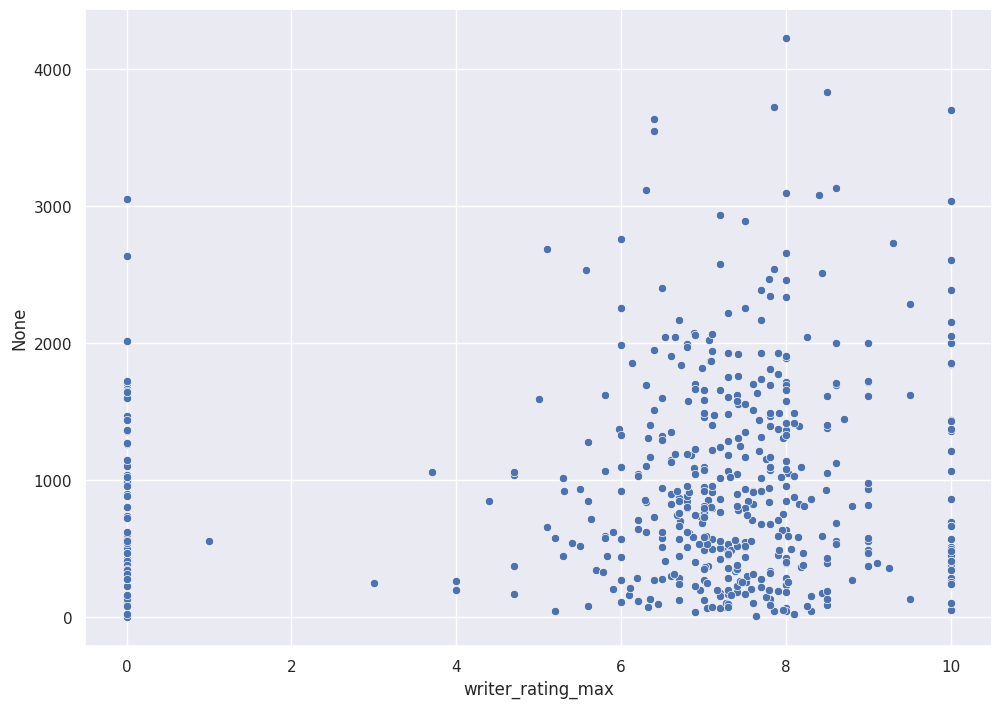

In [75]:
fig1 = plt.figure()
sns.scatterplot(data=final, x='writer_rating_max', y=abs_y, ax=fig1.gca())
plt.show()